## Monte Carlo

There exists some set of optimum policies that maximize the agent's total returns over time. These are defined in terms of some optimal action-value functions. In this notebook, we're going to set about the business of actually finding those action-value functions and policies. We're going to use what are called Monte Carlo methods to do this. These are a class of algorithms that effectively learn from experience and require no model or prior knowledge of the environment the agent will learn by keeping track of the rewards it receives every time it encounters a state and then averaging that sequence of rewards by playing enough games. The agent will get a good sampling of each state and calculate an accurate value of each given state. These estimates are updated once per episode and end by replaying the memory of states encountered, and rewards received.

Finding the optimal action-value functions and then using that to optimize the policy is two discrete sets of operations. Some algorithms calculate the state value and action-value functions, and then there are some algorithms for finding the optimal policies. These are called the prediction and control problems. These two classes of algorithms play together in a framework known as generalized policy iteration. We start with some policy, calculate its action-value function and then approve the policy by making it greedy with respect to the current value. We can do both policy evaluation and improvement simultaneously in a sequence, or we can do them one at a time. We can update values for all possible states or only the states that are convenient and so on. What matters here is that we're both evaluating in improving the policy in generalized policy iteration. We calculate the action-value of a given policy by keeping track of the states the agent saw and the rewards it received and then take the average of the rewards at the end of the episode as a function of the states it encountered. We repeat this process for many episodes. 

We test our algorithms using the OpenAI blackjack environment, where the goal is to win as many games. The state-space is a tree-tuple. The player's total sum, the dealer showing card, and a boolean for usable ace. 

**References:**
- https://gym.openai.com/envs/Blackjack-v0/
- https://github.com/philtabor/Actor-Critic-Methods-Paper-To-Code

## Import Libraries

In [1]:
import gym
import random
import numpy as np

from ipynb.fs.full.Plotting import *
import matplotlib.pyplot as plt

In [114]:
random.seed(2021)

## Reinforcement Learning Agent

In [177]:
class Agent():
    def __init__(self, observation_space, action_space, dealer_observation_space, usable_ace, discount_rate = 0.99,
                 exploration_rate = 0.001):
        
        self.observation_space = observation_space
        self.action_space = action_space
        self.dealer_observation_space = dealer_observation_space
        self.usable_ace = usable_ace
        
        self.exploration_rate = exploration_rate
        self.discount_rate = discount_rate

        self.Q = {}
        self.returns = {}
        self.pairs_visited = {} # First visit.

        self.memory = []
        self.state_space = []

        self.initialization()

    def initialization(self):
        policy = {}
        for total in range(self.observation_space):
            for card in range(self.dealer_observation_space):
                for ace in range(self.usable_ace):
                    observation = (total, card, ace)
                    self.state_space.append(observation)
                    for action in range(self.action_space):
                        self.Q[(observation, action)] = 0
                        self.returns[(observation, action)] = []
                        self.pairs_visited[(observation, action)] = 0
                    

        for observation in self.state_space:
            policy[observation] = [1/self.action_space for _ in range(self.usable_ace)]
        self.policy = policy
            
    def choose_action(self, observation):
        action = np.random.choice(self.action_space, p = self.policy[observation])
        return action

    def update_Q(self):
        for index, (observation, action, _) in enumerate(self.memory):
            G = 0
            discount = 1
            if self.pairs_visited[(observation, action)] == 0:
                self.pairs_visited[(observation, action)] += 1
                for (_, _, reward) in self.memory[index:]:
                    G += reward * discount
                    discount *= self.discount_rate
                    self.returns[(observation, action)].append(G)

        for observation, action, _ in self.memory:
            self.Q[(observation, action)] = np.mean(self.returns[(observation, action)])
            self.update_policy(observation)

        for state_action in self.pairs_visited.keys():
            self.pairs_visited[state_action] = 0

        self.memory = []
        
    def update_policy(self, observation):
        actions = [self.Q[(observation, a)] for a in range(self.action_space)]
        a_max = np.argmax(actions)
        n_actions = self.action_space
        probs = []
        for action in range(self.action_space):
            prob = 1 - self.exploration_rate + self.exploration_rate / n_actions if action == a_max else \
                    self.exploration_rate / n_actions
            probs.append(prob)
        self.policy[observation] = probs

## Main Program

In [178]:
step = 0
episodes = 200000

starting episode 0 win rate 0.000
starting episode 50000 win rate 0.409
starting episode 100000 win rate 0.408
starting episode 150000 win rate 0.409


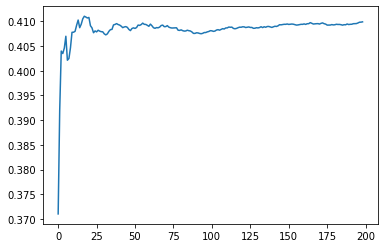

In [179]:
env = gym.make('Blackjack-v0')

observation_space = env.observation_space[0].n
action_space = env.action_space.n
dealer_observation_space = env.observation_space[1].n
usable_ace = env.observation_space[2].n
agent = Agent(observation_space, action_space, dealer_observation_space, usable_ace)

win_lose_draw = {-1:0, 0:0, 1:0}
win_rates = []

for i in range(episodes):
    if i > 0 and i % 1000 == 0:
        pct = win_lose_draw[1] / i
        win_rates.append(pct)
    if i % 50000 == 0:
        rates = win_rates[-1] if win_rates else 0.0
        print('starting episode', i, 'win rate %.3f' % rates)
    observation = env.reset()
    done = False
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        agent.memory.append((observation, action, reward))
        observation = observation_
    agent.update_Q()
    win_lose_draw[reward] += 1
plt.plot(win_rates)
plt.show()